In [1]:
import os
import random
from fenics import *
from dolfin import *
import numpy as np
import sys

comm = MPI.comm_world
rank = MPI.rank(comm)

set_log_level(50)

# generate mesh

nx, ny = 60, 120
LX, LY = 128, 256
mesh = RectangleMesh(Point(0, 0), Point(LX, LY), nx, ny)

class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                    (not ((near(x[0], 0) and near(x[1], LY)) or
                          (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY


#####################################################################################################
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim=2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain=PeriodicBoundary())
FS = FunctionSpace(mesh, Q, constrained_domain=PeriodicBoundary())

In [2]:
w = Function(FS)

u_new = Function(MFS)
(rho, tau) = split(u_new)

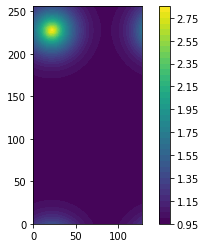

In [3]:
Hdf = HDF5File(comm, f"forward_w_0.05_lmd_0.8_time_2_seed_12345.h5", 'r')
Hdf.read(u_new, f"u_new/Vector/vector_9999")

import matplotlib.pyplot as plt
c = plot(rho)
plt.colorbar(c)

In [4]:
mesh_fine = RectangleMesh(Point(0, 0), Point(LX, LY), 2*nx, 2*ny)

Q_fine = FiniteElement("Lagrange", mesh_fine.ufl_cell(), 1)
FS_fine = FunctionSpace(mesh_fine, Q_fine, constrained_domain=PeriodicBoundary())

In [6]:
def fenics_to_numpyarray(rho):
    
    x = np.linspace(0, LX, 2*nx +1)
    y = np.linspace(0, LY, 2*ny + 1)
    xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')
    
    rho_ = project(rho, FS_fine)
    rho_vec = np.vectorize(rho_)
    rho_ar = rho_vec(xx, yy)
    
    return rho_ar


def numpyarray_to_fenics(rho_ar):
    
    rho__ = Function(FS_fine)

    # Get the local to global DoF map
    dof_map = vertex_to_dof_map(FS_fine)

    # Copy the data from the NumPy array to the Function
    for i in range(FS_fine.dim()):
        rho__.vector()[dof_map[i]] = rho_ar.flatten()[i]

    return rho__



In [12]:
def roll(x_roll, y_roll, rho_ar):
    
    # Perform a circular shift along rows (axis=0)
    shifted_rows = np.roll(rho_ar, shift=x_roll, axis=0)

    # Perform a circular shift along columns (axis=1)
    rho_shifted = np.roll(shifted_rows, shift=y_roll, axis=1)
    
    return rho_shifted


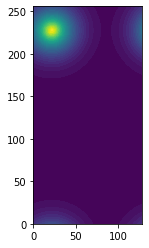

In [56]:
plot(rho)

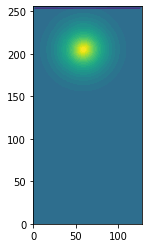

In [66]:
rho_fine = Function(FS_fine)
rho_fine = project(rho, FS_fine)
rho_ar_fine = fenics_to_numpyarray(rho_fine)


rho_ar_fine = roll(35, 220, rho_ar_fine)

rho_new = Function(FS_fine)
rho_new = numpyarray_to_fenics(rho_ar_fine.T)

rho_coarse = project(rho_new, FS)
plot(rho_coarse)

In [53]:
# project the fenics function to finer mesh -> map to numpy array on finer mesh and do operations (roll) 
# -> convert numpy array into fenics function -> project the fenics function back to coarser mesh

tf = TestFunction(MFS)
(q, v) = split(tf)

Hdf_target = HDF5File(comm, f"aster_trajectory.h5", 'w')
count = 0

for y in range(70, 220):

    rho_fine = Function(FS_fine)
    rho_fine = project(rho, FS_fine)
    rho_ar_fine = fenics_to_numpyarray(rho_fine)


    rho_ar_fine = roll(35, y, rho_ar_fine)

    rho_new = Function(FS_fine)
    rho_new = numpyarray_to_fenics(rho_ar_fine.T)

    rho_coarse = project(rho_new, FS)

    ######################################################
    rho_fine = Function(FS_fine)
    rho_fine = project(tau[0], FS_fine)
    rho_ar_fine = fenics_to_numpyarray(rho_fine)


    rho_ar_fine = roll(35, y, rho_ar_fine)

    rho_new = Function(FS_fine)
    rho_new = numpyarray_to_fenics(rho_ar_fine.T)

    taux_coarse = project(rho_new, FS)

    #######################################################

    rho_fine = Function(FS_fine)
    rho_fine = project(tau[1], FS_fine)
    rho_ar_fine = fenics_to_numpyarray(rho_fine)


    rho_ar_fine = roll(35, y, rho_ar_fine)

    rho_new = Function(FS_fine)
    rho_new = numpyarray_to_fenics(rho_ar_fine.T)

    tauy_coarse = project(rho_new, FS)


    ########################################################

    tau_com = as_vector([taux_coarse, tauy_coarse])

########################################################

    test = Function(MFS)
    (testx, testy) = split(test)

    Res_0 = testx*q*dx - rho_coarse*q*dx
    Res_1 = dot(testy, v)*dx - dot(tau_com, v)*dx

    Res = Res_0 + Res_1

    solve(Res == 0, test)


    Hdf_target.write(test, f"u_new/Vector/vector_{count}")
    
    count = count + 1
    
Hdf_target.close()

Calling FFC just-in-time (JIT) compiler, this may take some time.
